In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
alpha = 1 # proximal term coefficient
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

m = num_agents = 100
n = 25

filename = "local_ot_N%d_%.2f_n%d"%(num_points, eps_sublevel, num_agents)

In [4]:
C, a, A_eq, b_eq, A_ineq, b_ineq, volumes, mean = mra.ot_data(m, n)

In [5]:
b_norm = (np.linalg.norm(b_eq)**2 + np.linalg.norm(b_ineq)**2)**0.5
C.shape

(100, 25)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_solution_ot(C, a, A_eq, b_eq, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=1.1519520887311967


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.5881310993082995

In [8]:
true_x.shape, true_lamb.shape

((2500, 1), (50, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       eps_sublevel=eps_sublevel, num_points=K)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.ot_query_multiple_actions_noisy_prices(lamb_k, C[i:i+1].T, a[i, 0], vol_i=volumes[i, 0], 
                                                                       percent=percent, num_points=K)]


fun_obj_val = lambda x_k: mra.ot_obj_value(x_k, C, a, b_eq)

# Localization

In [10]:
price_min, price_max = mra.ot_prime_initial_bound(true_lamb, A_eq, b_eq, A_ineq, b_ineq)

K_i = num_points
N = num_agents
primal_var_size = A_eq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, A_eq=A_eq, b_eq=b_eq,
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, A_eq=A_eq, b_eq=b_eq,
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=6.0603E-02,  viol_xk=3.9352E+00, viol_mra=1.0729E+00, lamb_rel_diff=INF
epoch=50, f_subopt_xk=1.4956E-02,  f_subopt_mra=5.7826E-02,  viol_xk=7.2104E-01, viol_mra=4.4663E-03, lamb_rel_diff=6.3128E-02
epoch=99, f_subopt_xk=4.2310E-02,  f_subopt_mra=8.0072E-02,  viol_xk=6.5257E-01, viol_mra=2.9650E-02, lamb_rel_diff=4.6201E-02
epoch=0, f_subopt_xk=3.0519E-01,  f_subopt_mra=2.2284E-01,  viol_xk=3.9352E+00, viol_mra=2.5355E+00, lamb_rel_diff=INF
epoch=50, f_subopt_xk=1.4956E-02,  f_subopt_mra=2.7027E-02,  viol_xk=7.2104E-01, viol_mra=2.5740E-01, lamb_rel_diff=6.3128E-02
epoch=99, f_subopt_xk=4.2310E-02,  f_subopt_mra=1.3417E-02,  viol_xk=6.5257E-01, viol_mra=1.5509E-01, lamb_rel_diff=4.6201E-02


In [12]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

T=100
0.04231040527005691 sub_eps 0.08007193225271116 noisy_y 0.013417309740453874 proj inf


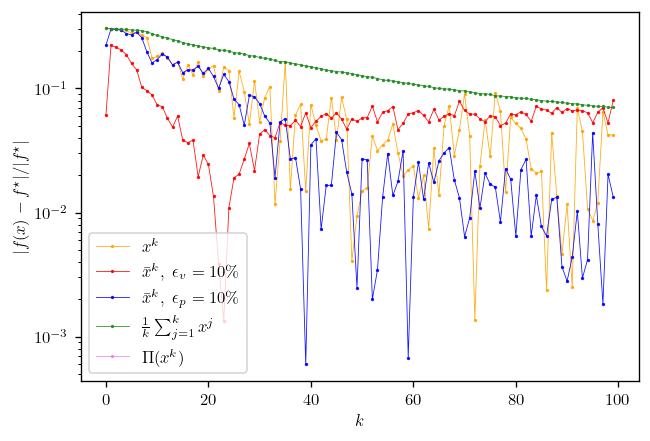

In [13]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename, T=100)

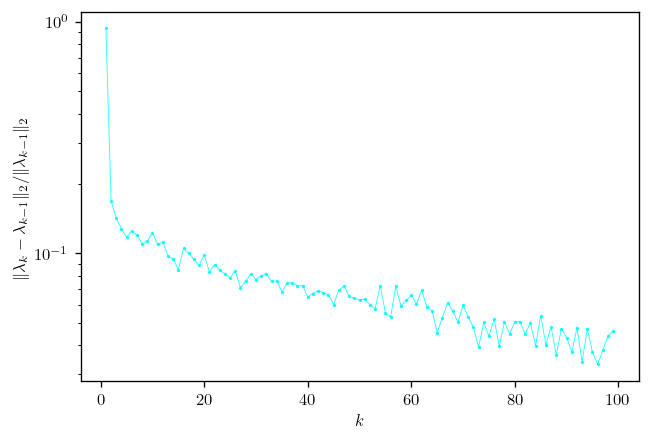

In [14]:
mra.plot_lamb_k_diff(all_res, filename)

In [15]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

0.5568460595286764 sub_eps 0.028336882516436318 noisy_y 0.13127354179151451


In [16]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 100 noisy_y 100


T=100
0.9553516798625584 sub_eps 0.04861610825990098 noisy_y 0.22521915442516063


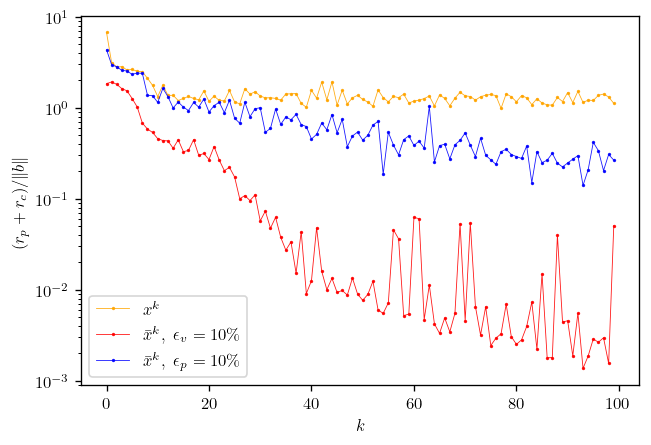

In [17]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename, T=100)

T=100
0.9553516798625584 sub_eps 0.04861610825990098 noisy_y 0.22521915442516063


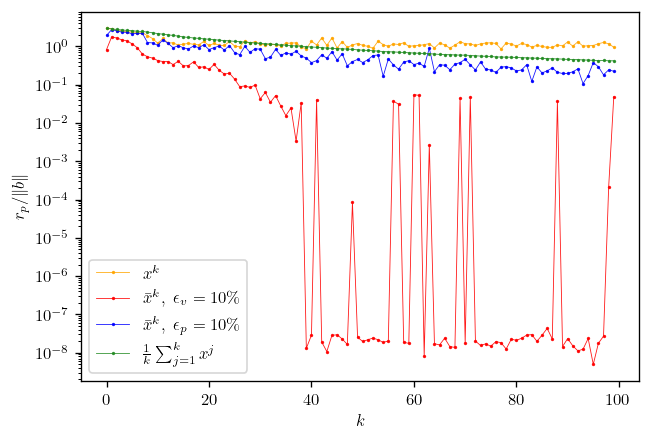

In [18]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename, T=100)

T=100


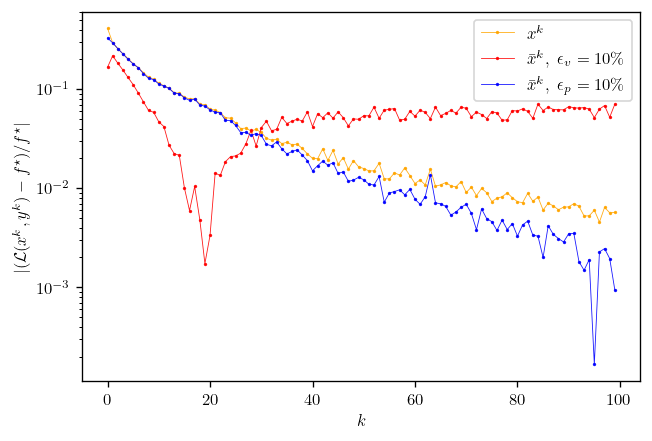

In [19]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename, T=100)

In [26]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = np.argmin(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]))
idx_eps = np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]


print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=77, idx_eps=39, idx_noisy_y=93, idx_paverage=99
xk 0.06568353694579333 sub_eps 0.06362923551097073 noisy_y 0.002962029815504456 proj inf paverage 0.07028441170870925
xk 0.5021148334826049 sub_eps 7.60545606093982e-09 noisy_y 0.062426942045054654 paverage 0.24577254216901367


In [28]:
0.5021148334826049/0.062426942045054654, 0.24577254216901367/0.062426942045054654

(8.043239297549118, 3.936962697798575)

In [21]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
# with open(f"../results/{filename}_dict.pkl", "rb") as file:
#     res = pickle.load(file)
# res["eps"].keys()

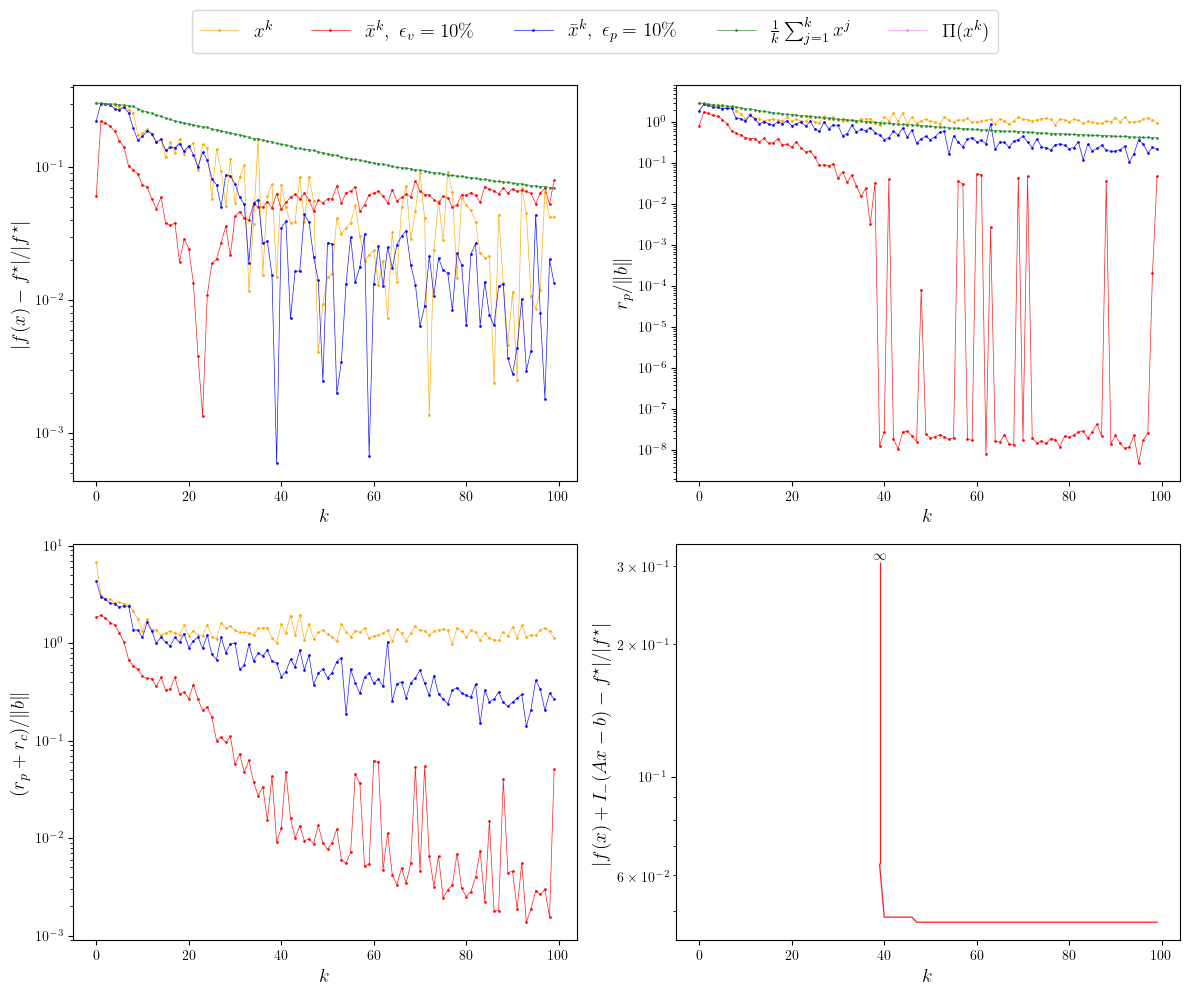

In [22]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)